In [1]:
from skimage.data import brain
from skimage.transform import resize, radon, iradon
import numpy as np
import torch, torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

In [2]:
#Setup 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nxd = 182
theta = np.linspace(0., 180., max(nxd, 180), endpoint=False)

In [ ]:
#Function to add Poisson noise to the sinogram

def add_poisson(sino, scale):
    
    scaled_sino = sino * scale

    scaled_sino = np.clip(scaled_sino, 0, 1e6)

    #Generate Posson distributed random values with mean = scaled_sino
    noisy = np.random.poisson(scaled_sino)

    return noisy / scale

def mlem_reco(sino, azi_angles, num_its: int):
    #Define reconstructed image
    image_size = sino.shape[0]   #define image reco size based on sinogram height
    mlem_rec = np.ones((image_size, image_size))

    #Compute sensitivity image (A^T 1)
    sens_image = iradon(
        np.ones_like(sino),
        azi_angles,
        circle=True,
        filter_name=None,
        output_size=image_size
    )

    for iter in range(num_its):  
        fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
        #print(fp.shape)

        ratio = sino / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
        correction = iradon(ratio, azi_angles, circle=True , filter_name=None, output_size=image_size) / (sens_image + 0.000001) # No filter because we are just getting the transpose A^T

        mlem_rec = mlem_rec * correction

    return mlem_rec

def crop_to_square(img):
    h, w = img.shape
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    return img[top:top + min_dim, left:left + min_dim]

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp ( - (x - mean)**2 / (2 * standard_deviation **2))

def scal_func(n, av_counts): 
    r = n/100
    x = 1 / ( (r**2)*(av_counts) )
    return x

In [4]:
#Reading in CT scan Data 
import nibabel as nib
import random

#Parameters
z_half_window = 4
t_half_window = 2
rel_noise = [None, 1, 3, 5, 10]

#Load files
paths = [
    "LondonPride_000101_dynPET.img",
    "LondonPride_000102_dynPET.img",
    "LondonPride_000103_dynPET.img",
    "LondonPride_000104_dynPET.img",
    "LondonPride_000105_dynPET.img",
]

images = []
sinograms = []

for p in paths:

    img = nib.load(p)
    pet_data = img.get_fdata(dtype=np.float32)

    # Get full Z range and calculate start and end
    total_slices = pet_data.shape[2]
    center = total_slices // 2
    z_start = center - z_half_window
    z_end = center + z_half_window

    # Just to be safe:
    z_start = max(0, z_start)
    z_end = min(total_slices, z_end)

    #print(z_start, z_end)

    # Get full t range and calculate start and end
    total_slices = pet_data.shape[3]
    center = total_slices // 2
    t_start = center - t_half_window
    t_end = center + t_half_window

    # Just to be safe:
    t_start = max(0, t_start)
    t_end = min(total_slices, t_end)

    #print(t_start, t_end)

    for t in range(t_start, t_end): #Time framse
        for z in range(z_start, z_end): #Central 100 slices

            slice_img = pet_data[:, :, z, t]

            image_cropped = crop_to_square(slice_img)
            image_resized = resize(image_cropped, (nxd, nxd), anti_aliasing=True)
            images.append(image_resized.astype(np.float32))
        
            # Generate sinogram
            sino_clean = radon(image_resized, theta=theta, circle=True)

            noise_choice = random.choice(rel_noise)

            if noise_choice is None:
                sinograms.append(sino_clean)
            else:
                counts_bin = sino_clean.ravel()
                bin_heights, bin_edges = np.histogram(counts_bin, bins=50)
                bin_centres = bin_edges[:-1] + np.diff(bin_edges) / 2

                # 1) Clean/weight the data (avoid zeros/NaNs and use Poisson weights)
                mask = np.isfinite(bin_heights) & np.isfinite(bin_centres) & (bin_heights > 0)
                x = bin_centres[mask]
                y = bin_heights[mask]
                sigma_w = np.sqrt(y)            # Poisson stdev
                sigma_w[sigma_w == 0] = 1.0     # safety

                # 2) Data-driven initial guesses
                A0 = y.max()
                # weighted mean & std as starting points
                mu0 = np.average(x, weights=y)
                sigma0 = np.sqrt(np.average((x - mu0)**2, weights=y))
                # fallback if sigma0 is tiny/NaN
                if not np.isfinite(sigma0) or sigma0 <= 0:
                    sigma0 = (x.max() - x.min())/6.0

                p0 = [A0, mu0, sigma0]

                # 3) Constrain parameters to sensible ranges and allow more iterations
                lower = [0, x.min(), 1e-9]      # A>=0, mu in data range, sigma>0
                upper = [np.inf, x.max(), np.inf]

                popt, pcov = curve_fit(
                    gaussian, x, y,
                    p0=p0,
                    sigma=sigma_w,
                    absolute_sigma=True,   # interpret sigma as true stdevs
                    bounds=(lower, upper), # enables robust 'trf' solver internally
                    maxfev=20000           # more function evaluations
                    )

                av_counts = popt[0]
                #print(av_counts)
                scale = scal_func(noise_choice, av_counts)
                sino_noisy = add_poisson(sino_clean, scale)
                sinograms.append(sino_noisy)

/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(
/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


In [5]:
# Convert to NumPy arrays
images = np.array(images)
sinograms = np.array(sinograms)

print(len(images))
print(len(sinograms))

# Split into train, val, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(sinograms, images, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

160
160
Train: 128, Val: 28, Test: 4


In [6]:
#Class to get the datasets (sinograms/images) in a format that pytorch can use
class MLEMDataset(Dataset):
    def __init__(self, sinograms, images):
        self.sinograms = sinograms
        self.images = images

    def __len__(self):
        return len(self.sinograms)
    
    #Enables use to get one item at a time
    def __getitem__(self, idx):
        sino = torch.from_numpy(self.sinograms[idx]).float()
        img = torch.from_numpy(self.images[idx]).float()
        return sino, img
    
train_dataset = MLEMDataset(X_train, y_train)
val_dataset = MLEMDataset(X_val, y_val)
test_dataset = MLEMDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [7]:
#Functions

#Convert numpy to torch
def np_to_torch(x):
    return torch.from_numpy(x).float().to(device)

#Convert torch to numpy
def torch_to_np(x):
    return x.detach().cpu().numpy()

#MLEM forward and backward projections
def forward_proj(image_np):
    return radon(image_np, theta=theta, circle=True)

def back_proj(sino_np):
    return iradon(sino_np, theta=theta, circle=True, filter_name = None)

#Torch versions
def fp_torch(image):
    return np_to_torch(forward_proj(torch_to_np(image)))

def bp_torch(sino):
    return np_to_torch(back_proj(torch_to_np(sino)))

In [8]:
#CNN Architecture 

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 5, padding=(2,2)), nn.PReLU(),
            nn.Conv2d(8, 8, 3, padding=(1,1)), nn.PReLU(),
            nn.Conv2d(8, 8, 5, padding=(2,2)), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=(3,3))
        )
    def forward(self, x):
        return self.net(x)
    
cnn = CNN().to(device)

In [ ]:
#MLEM and CNN model

class intraCNN(nn.Module):
    def __init__(self, cnn, num_its):
        super().__init__()
        self.cnn = cnn
        self.num_its = num_its

    def forward(self, sino):
        sino = sino.to(device)
        sens = bp_torch(torch.ones_like(sino))
        recon = torch.ones_like(sino)
        iters = self.num_its

        for _ in range(iters):
            fp = fp_torch(recon)
            ratio = sino / (fp + 1e-9)
            correction = bp_torch(ratio) / (sens + 1e-9)
            recon = recon * correction

            #CNN Enhancement
            recon = recon.unsqueeze(0).unsqueeze(0) #[1, 1, H, W]
            recon = recon + self.cnn(recon)
            recon = recon.squeeze() #[H, W]
            recon = torch.abs(recon)

        return recon


In [ ]:
#Instantiate the model
num_its = 10
cnn_mlem = intraCNN(cnn, num_its).to(device)

In [11]:
#Training the CNN
from tqdm import tqdm

loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(cnn_mlem.parameters(), lr = 1e-3)

train_loss = []
val_loss = []
epochs = 20

for ep in range(epochs):
    cnn_mlem.eval()
    running_train_loss = 0 

    for sino, target in tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}", leave=False):

        sino = sino.squeeze(0).to(device)
        target = target.squeeze(0).to(device)

        output = cnn_mlem(sino)
        loss = loss_fn(output, target)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        running_train_loss += loss.item()
    
    train_loss.append(running_train_loss / len(train_loader))

    #Validation
    cnn_mlem.eval()
    running_val_loss = 0
    with torch.no_grad():
        for val_sino, val_target in tqdm(val_loader, desc="Validation", leave=False):
            val_sino = val_sino.squeeze(0).to(device)
            val_target = val_target.squeeze(0).to(device)
            val_output = cnn_mlem(val_sino)
            val_loss_val = loss_fn(val_output, val_target)
            running_val_loss += val_loss_val.item()

    val_loss.append(running_val_loss / len(val_loader))
    print(f"Epoch {ep+1} | Train Loss: {train_loss[-1]:.6f} | Val Loss: {val_loss[-1]:.6f}")

Epoch 1/20:   0%|          | 0/128 [00:00<?, ?it/s]/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Epoch 1 | Train Loss: 3.989756 | Val Loss: 3.108270


Epoch 2 | Train Loss: 2.930520 | Val Loss: 2.859810


Epoch 3 | Train Loss: 2.711013 | Val Loss: 3.152437


Epoch 4 | Train Loss: 2.904367 | Val Loss: 2.865662


Epoch 5 | Train Loss: 2.617821 | Val Loss: 2.711823


Epoch 6 | Train Loss: 2.677660 | Val Loss: 3.108045


Epoch 7 | Train Loss: 2.687584 | Val Loss: 3.023008


Epoch 8 | Train Loss: 2.520604 | Val Loss: 2.636046


Epoch 9 | Train Loss: 2.543552 | Val Loss: 2.826906


Epoch 10 | Train Loss: 2.472809 | Val Loss: 2.881599


Epoch 11 | Train Loss: 2.631275 | Val Loss: 2.562597


Epoch 12 | Train Loss: 2.525880 | Val Loss: 2.750458


Epoch 13 | Train Loss: 2.400926 | Val Loss: 2.625375


Epoch 14 | Train Loss: 2.478979 | Val Loss: 2.591572


Epoch 15 | Train Loss: 2.399118 | Val Loss: 2.635481


Epoch 16 | Train Loss: 2.457894 | Val Loss: 2.471100


Epoch 17 | Train Loss: 2.436946 | Val Loss: 2.636653


Epoch 18 | Train Loss: 2.653943 | Val Loss: 2.618022


Epoch 19 | Train Loss: 2.394447 | Val Loss: 2.695998


Epoch 20 | Train Loss: 2.599089 | Val Loss: 2.768038


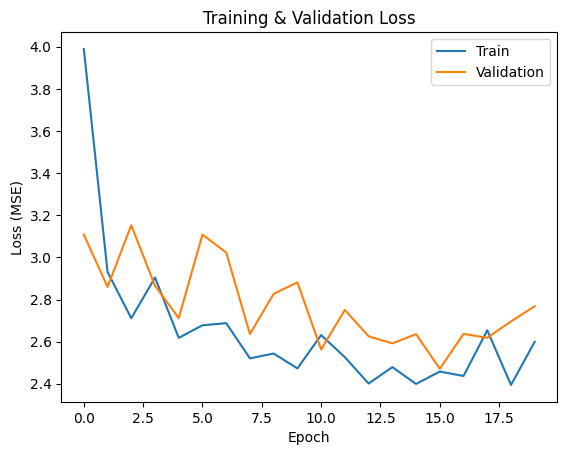

In [12]:
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [ ]:
'''# Comparison plot
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

cnn_mlem.eval()

mlem_mses = []
mlem_ssims = []
cnn_mses = []
cnn_ssims = []

examples = []

with torch.no_grad():
    for idx, (sino, target) in enumerate(test_loader):
        sino_np = sino.squeeze(0).numpy()
        target_np = target.squeeze(0).numpy()

        # ----- MLEM only -----
        reco_mlem = mlem_reco(sino_np, theta, num_its)
        mse_mlem = mean_squared_error(target_np, reco_mlem)
        ssim_mlem = ssim(target_np, reco_mlem, data_range=target_np.max() - target_np.min())

        mlem_mses.append(mse_mlem)
        mlem_ssims.append(ssim_mlem)

        # ----- MLEM + CNN -----
        sino = sino.squeeze(0).to(device)
        reco_cnn = cnn_mlem(sino).cpu().numpy()
        mse_cnn = mean_squared_error(target_np, reco_cnn)
        ssim_cnn = ssim(target_np, reco_cnn, data_range=target_np.max() - target_np.min())

        cnn_mses.append(mse_cnn)
        cnn_ssims.append(ssim_cnn)

        # Save examples
        if idx < 2:
            examples.append((target_np, reco_mlem, reco_cnn, mse_mlem, ssim_mlem, mse_cnn, ssim_cnn))

# ---- Print Averages ----
print("\nAverage Metrics on Test Set")
print(f"MLEM Only   - MSE: {np.mean(mlem_mses):.4f}, SSIM: {np.mean(mlem_ssims):.4f}")
print(f"MLEM + CNN  - MSE: {np.mean(cnn_mses):.4f}, SSIM: {np.mean(cnn_ssims):.4f}")'''


Average Metrics on Test Set
MLEM Only   - MSE: 19.4718, SSIM: 0.4767
MLEM + CNN  - MSE: 4.8579, SSIM: 0.8352


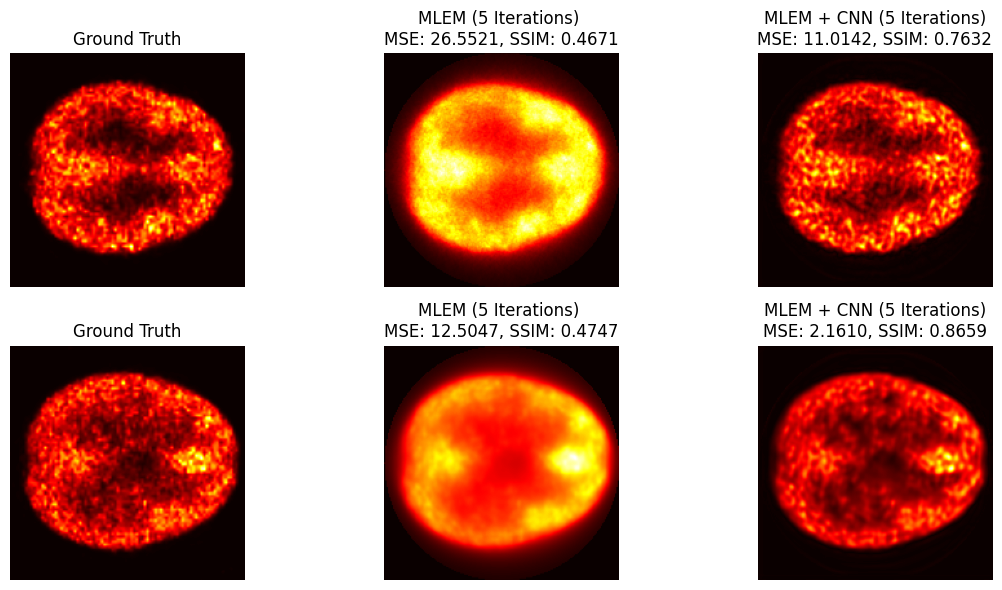

In [ ]:
'''fig, axs = plt.subplots(len(examples), 3, figsize=(12, 3 * len(examples)))

for i, (true_img, mlem_img, cnn_img, mse_val_mlem, ssim_val_mlem, mse_cnn, ssim_cnn) in enumerate(examples):
    axs[i, 0].imshow(true_img, cmap='hot')
    axs[i, 0].set_title("Ground Truth")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mlem_img, cmap='hot')
    axs[i, 1].set_title(f"MLEM ({num_its} Iterations) \nMSE: {mse_val_mlem:.4f}, SSIM: {ssim_val_mlem:.4f}")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(cnn_img, cmap='hot')
    axs[i, 2].set_title(f"MLEM + CNN ({num_its} Iterations)\nMSE: {mse_cnn:.4f}, SSIM: {ssim_cnn:.4f}")
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()'''

In [13]:
#Getting the MLEM reconstructed images
mlem_train, mlem_val, mlem_test = [], [], []

for sino, _ in train_dataset:
    sino = torch_to_np(sino)
    mlem_train.append(mlem_reco(sino, theta, 5))

for sino, _ in val_dataset:
    sino = torch_to_np(sino)
    mlem_val.append(mlem_reco(sino, theta, 5))

for sino, _ in test_dataset:
    sino = torch_to_np(sino)
    mlem_test.append(mlem_reco(sino, theta, 5))

mlem_train = np.array(mlem_train)
mlem_val = np.array(mlem_val)
mlem_test = np.array(mlem_test)

In [14]:
train_dataset = MLEMDataset(mlem_train, y_train)
val_dataset = MLEMDataset(mlem_val, y_val)
test_dataset = MLEMDataset(mlem_test, y_test)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

mlem_train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
mlem_val_loader = DataLoader(val_dataset, batch_size=10)
mlem_test_loader = DataLoader(test_dataset, batch_size=10)

Train: 128, Val: 28, Test: 4


In [ ]:
class extraCNN(nn.Module):
    def __init__(self):
        super(extraCNN, self).__init__()
        self.CNN_denoise = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 5, padding=(2,2)), nn.PReLU(),
            nn.Conv2d(8, 8, 3, padding=(1,1)), nn.PReLU(),
            nn.Conv2d(8, 8, 5, padding=(2,2)), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=(3,3))
        )

    def forward(self, x):
        return x + self.CNN_denoise(x)

In [ ]:
from tqdm import tqdm

model = extraCNN().to(device)
loss_function = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.003)

train_loss_history, val_loss_history = [], []
epochs = 20

for epoch in range(epochs):

    model.eval()
    running_train_loss = 0

    for mlem_im, target in tqdm(mlem_train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):

        # Expect [B, 1, H, W]; add channel dim if missing
        if mlem_im.ndim == 3:  # [B, H, W]
            mlem_im = mlem_im.unsqueeze(1)
        if target.ndim == 3:
            target = target.unsqueeze(1)

        mlem_im = mlem_im.to(device).float()
        target  = target.to(device).float()

        output = model(mlem_im)
        loss = loss_function(output, target)
        loss.backward()
        optim.step()
        optim.zero_grad()

        running_train_loss += loss.item()

    train_loss_history.append(running_train_loss / len(mlem_train_loader))

    #Validation

    model.eval()
    running_val_loss = 0

    with torch.no_grad():

            for val_mlem_im, val_target in tqdm(mlem_val_loader, desc="Validation", leave=False):
                if val_mlem_im.ndim == 3:
                    val_mlem_im = val_mlem_im.unsqueeze(1)
                if val_target.ndim == 3:
                    val_target = val_target.unsqueeze(1)

                val_mlem_im = val_mlem_im.to(device).float()
                val_target  = val_target.to(device).float()

                val_output = model(val_mlem_im)
                val_loss = loss_function(val_output, val_target)
                running_val_loss += val_loss.item()

    val_loss_history.append(running_val_loss / len(mlem_val_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_loss_history[-1]:.6f} | Val Loss: {val_loss_history[-1]:.6f}")

Epoch 1 | Train Loss: 14.306772 | Val Loss: 13.953522


Epoch 2 | Train Loss: 11.446418 | Val Loss: 7.839868


Epoch 3 | Train Loss: 10.197742 | Val Loss: 8.626300


Epoch 4 | Train Loss: 8.056924 | Val Loss: 7.640946


Epoch 5 | Train Loss: 7.186897 | Val Loss: 6.979530


Epoch 6 | Train Loss: 6.581566 | Val Loss: 6.332901


Epoch 7 | Train Loss: 5.849195 | Val Loss: 5.527947


Epoch 8 | Train Loss: 5.255702 | Val Loss: 5.867914


Epoch 9 | Train Loss: 5.064114 | Val Loss: 4.830787


Epoch 10 | Train Loss: 4.617097 | Val Loss: 4.560803


Epoch 11 | Train Loss: 4.441340 | Val Loss: 4.550144


Epoch 12 | Train Loss: 4.255478 | Val Loss: 4.235211


Epoch 13 | Train Loss: 4.135133 | Val Loss: 5.022430


Epoch 14 | Train Loss: 4.693729 | Val Loss: 4.710917


Epoch 15 | Train Loss: 4.396936 | Val Loss: 4.315066


Epoch 16 | Train Loss: 4.012550 | Val Loss: 3.985141


Epoch 17 | Train Loss: 3.818564 | Val Loss: 3.826914


Epoch 18 | Train Loss: 3.658595 | Val Loss: 3.800840


Epoch 19 | Train Loss: 3.668876 | Val Loss: 3.662419


Epoch 20 | Train Loss: 3.547086 | Val Loss: 3.684022


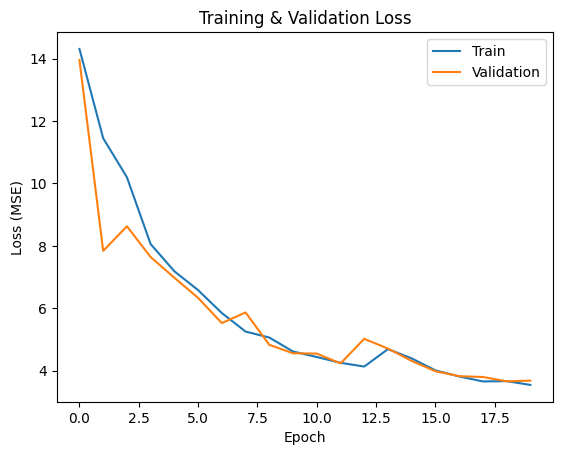

In [17]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

torch.Size([182, 182])
(182, 182)


Text(0.5, 1.0, 'Distribution of Counts per bin in the Sinogram')

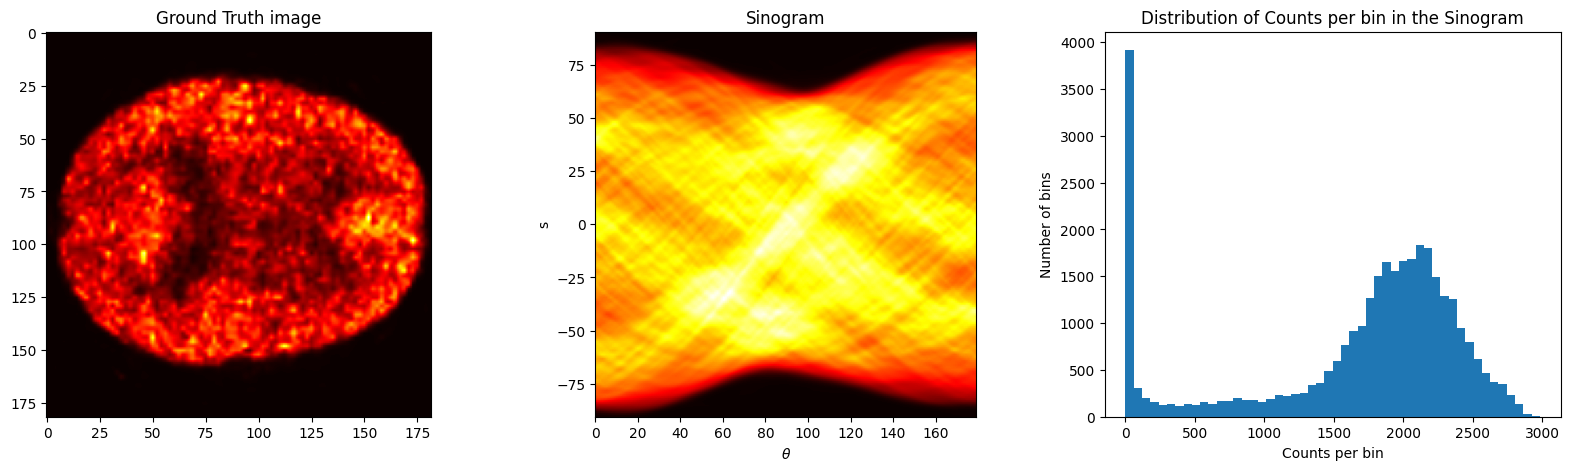

In [18]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Choose one test image for evaluation
test_idx = 3
sinogram_clean_np, true_image_np = test_dataset[test_idx]
sinogram_clean_np = radon(true_image_np, theta=theta, circle=True)
print(np.shape(true_image_np))
print(np.shape(sinogram_clean_np))

#Rescaling the y-axis of the sinogram

M = sinogram_clean_np.shape[0]
s = np.arange(M) - (M-1)/2.0

#Distribution of counts per bin

counts_bin = sinogram_clean_np.ravel()

#Plotting the True Image, Sinogram and distribution of bin counts for the sinogram

fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # <- use fig and axes

# Ground Truth Image
axes[0].imshow(true_image_np, cmap='hot')
axes[0].set_title('Ground Truth image')

# Sinogram
axes[1].imshow(sinogram_clean_np, extent=(theta.min(), theta.max(), s.min(), s.max()), cmap='hot')
axes[1].set_title('Sinogram')
axes[1].set_xlabel(r"$\theta$")
axes[1].set_ylabel(r"s")

#Bin Distribution 
axes[2].hist(counts_bin, bins=50) #ravel flattens array into a 1D array
axes[2].set_xlabel("Counts per bin")
axes[2].set_ylabel("Number of bins")
axes[2].set_title('Distribution of Counts per bin in the Sinogram')



Text(0, 0.5, 'Relative Noise (%)')

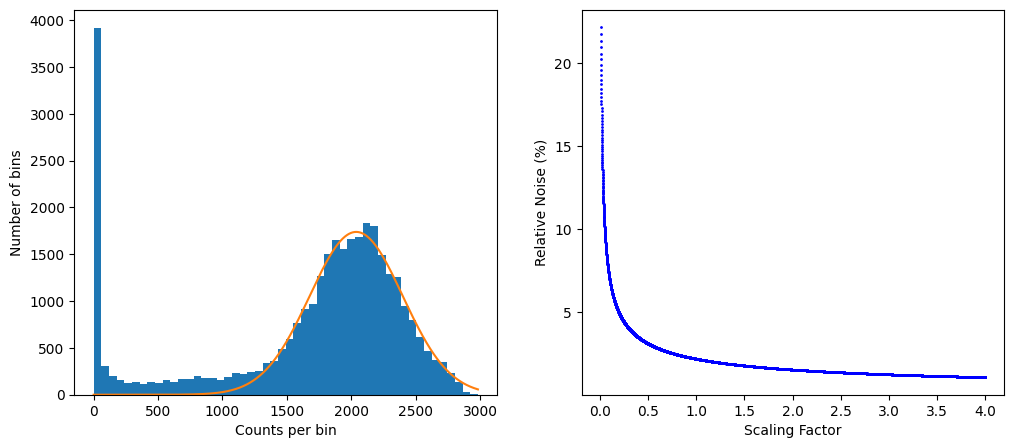

In [19]:


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Fitting a Gaussian to the Sinogram bin distribution 

def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp ( - (x - mean)**2 / (2 * standard_deviation **2))

bin_heights, bin_edges, _ = axes[0].hist(counts_bin, bins=50, label='Data')
bin_centres = bin_edges[:-1] + np.diff(bin_edges) / 2
popt, _ = curve_fit(gaussian, bin_centres, bin_heights, p0=[2000, 1500, 500])

x_interval_for_fit = np.linspace(bin_edges[0], bin_edges[-1], 10000)
axes[0].plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit')
axes[0].set_xlabel('Counts per bin')
axes[0].set_ylabel("Number of bins")

av_counts = popt[0]

def noise_func(x, av_counts):
    rel_noise = np.sqrt(av_counts * x) / (av_counts * x)
    return rel_noise * 100

x_array = np.linspace(0.01, 4, 10000)

axes[1].plot(x_array, noise_func(x_array, av_counts), 'bo', markersize=1)
axes[1].set_xlabel("Scaling Factor")
axes[1].set_ylabel("Relative Noise (%)")

In [23]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

test_idx = 3
mlem_np, true_image_np = test_dataset[test_idx]
mlem_np = mlem_np.numpy()
true_image_np = true_image_np.numpy()

sinogram_clean_np = radon(true_image_np, theta=theta, circle=True)

noise_levels = [1, 3, 5, 10]

mse_scores_cnn = []
ssim_scores_cnn = []
mse_scores_mlem = []
ssim_scores_mlem = []
mse_extra = []
ssim_extra = []

cnn_mlem.eval()
model.eval()

with torch.no_grad():
    for noise in noise_levels:

        scale = scal_func(noise, av_counts)

        noisy_sino = add_poisson(sinogram_clean_np, scale)
        
        # --- MLEM ---
        recon_mlem = mlem_reco(noisy_sino, theta, 20)
        mse_mlem = mean_squared_error(true_image_np, recon_mlem)
        ssim_mlem = ssim(true_image_np, recon_mlem, data_range=true_image_np.max() - true_image_np.min())
        mse_scores_mlem.append(mse_mlem)
        ssim_scores_mlem.append(ssim_mlem)

        # --- extra-CNN --- 
        inp = torch.from_numpy(recon_mlem).float().unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        out = model(inp)                                    # [1,1,H,W]
        mlem_cnn = out.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]

        mse_extra_val = mean_squared_error(true_image_np, mlem_cnn)
        ssim_val_denoise = ssim(true_image_np, mlem_cnn, data_range=true_image_np.max() - true_image_np.min())
        mse_extra.append(mse_extra_val)
        ssim_extra.append(ssim_val_denoise)

        # --- intra-CNN ---
        noisy_sino_torch = np_to_torch(noisy_sino)
        recon_cnn = cnn_mlem(noisy_sino_torch).cpu().numpy()
        mse = mean_squared_error(true_image_np, recon_cnn)
        ssim_val = ssim(true_image_np, recon_cnn, data_range=true_image_np.max() - true_image_np.min())
        mse_scores_cnn.append(mse)
        ssim_scores_cnn.append(ssim_val)


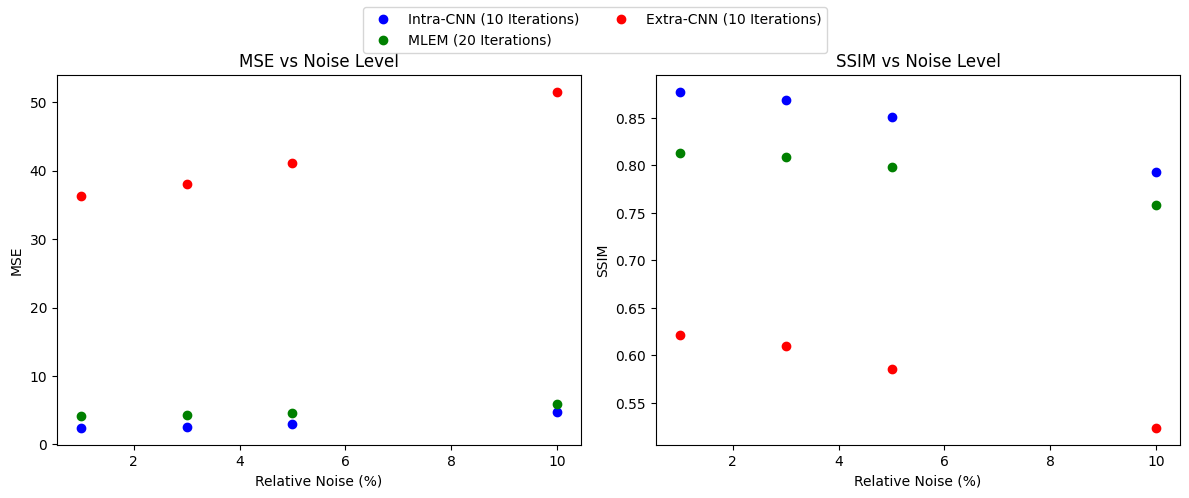

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # <- use fig and axes

# MSE plot
axes[0].plot(noise_levels, mse_scores_cnn, 'bo', label=f'Intra-CNN ({num_its} Iterations)')
axes[0].plot(noise_levels, mse_scores_mlem, 'go', label=f'MLEM (20 Iterations)')
axes[0].plot(noise_levels, mse_extra, 'ro', label=f'Extra-CNN ({num_its} Iterations)')
axes[0].set_xlabel('Relative Noise (%)')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE vs Noise Level')

# SSIM plot
axes[1].plot(noise_levels, ssim_scores_cnn, 'bo', label=f'Intra-CNN ({num_its} Iterations)')
axes[1].plot(noise_levels, ssim_scores_mlem, 'go', label=f'MLEM (20 Iterations)')
axes[1].plot(noise_levels, ssim_extra, 'ro', label=f'Extra-CNN ({num_its} Iterations)')
axes[1].set_xlabel('Relative Noise (%)')
axes[1].set_ylabel('SSIM')
axes[1].set_title('SSIM vs Noise Level')


# Unified legend above both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave room for the legend
plt.show()



In [22]:
# Choose one test image for evaluation
test_idx = 3
sinogram_clean_np, true_image_np = test_dataset[test_idx]
sinogram_clean_np = sinogram_clean_np.numpy()
true_image_np = true_image_np.numpy()
    
# --- MLEM ---
recon_mlem_it = mlem_reco(sinogram_clean_np, theta, 5)
mse_mlem_it = mean_squared_error(true_image_np, recon_mlem_it)
ssim_mlem_it = ssim(true_image_np, recon_mlem_it, data_range=true_image_np.max() - true_image_np.min())
print(f"The MSE for the MLEM algorithm is {mse_mlem_it}")
print(f"The SSIM for the MLEM algorithm is {ssim_mlem_it}")

# --- MLEM + CNN ---
recon_cnn_it = cnn_mlem(torch.tensor(sinogram_clean_np).to(device), num_its=5).detach().cpu().numpy()
mse_it = mean_squared_error(true_image_np, recon_cnn_it)
ssim_val_it = ssim(true_image_np, recon_cnn_it, data_range=true_image_np.max() - true_image_np.min())
print(f"The MSE for the MLEM + CNN algorithm is {mse_it}")
print(f"The SSIM for the MLEM + CNN algorithm is {ssim_val_it}")



The MSE for the MLEM algorithm is 163.28015023740414
The SSIM for the MLEM algorithm is 0.3279624168888764
The MSE for the MLEM + CNN algorithm is 163.79716700764502
The SSIM for the MLEM + CNN algorithm is 0.3227797393367597
